# LPGA 2022 Rolex Ranking

Author: Milan Nguyen

Course Project, UC Irvine, Math 10, S24

I would like to post my notebook on the course’s website. [Yes]



### Introduction:

Golf stats are often used a way to identify high and low points of a player's game rather than the outcome of a leaderboard or the Rolex Ranking. However, they may exist an association between these stats and a player's ranking. Thus, in this project I will be exploring the relationship between performance statistics and rankings. By applying different machine learning models on the LPGA 2022 dataset, the goal is to determine if an association exists between these stats and a player's ranking.

### Libraries and Imports Used

These are the different libraries and modules used for the project.

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

### The Dataset

The dataset used is the LPGA 2022 dataset from the UCI database, with a manually added column for the player's Rolex Ranking as of the last week of December 2022. 

In [80]:
df = pd.read_csv('lpga2022withRanking.csv')

### Cleaning Data

Since the ranking of the players in the dataframe vary drastically, only players within the top 100 will be selected for analysis to maintain consistency.

In [81]:
top_100 = df[df['RolexRanking'] <= 100].copy()

While total prize is in the dataframe, this value doesn't give us an accurate representation since prize money is dependent on how many events were played. Thus, the 'PrizeAvg' column was added to provide a normalized measure of the earnings by dividing the total prize money by the number of events played.

In [82]:
prize_avg = top_100['totPrize']/top_100['events']
top_100.loc[:, 'PrizeAvg'] = prize_avg

Next, several columns will be dropped since they can give an incorrect interpretation and skew the analysis. 

In [83]:
to_drop = ['Nation', 'Region', 'fairways', 'fairAtt', 'totPutts', 'totRounds', 'sandSaves', 'sandAtt', 'totPrize', 'events']
top_100.drop(to_drop, inplace=True, axis=1)

Checking for null values and ensuring unique entries is also important as to fill in the empty spaces and get rid of redundant rows. 

In [84]:
null_rows = top_100.loc[top_100.isnull().any(axis =1)]
unique_golfer = top_100['Golfer'].is_unique
print(null_rows)
print(unique_golfer)

Empty DataFrame
Columns: [Golfer, fairPct, avePutts, greenReg, driveDist, sandPct, RolexRanking, PrizeAvg]
Index: []
True


Because we want to see how each golfer fares in each category, the index of the top_100 dataframe will be set to 'Golfer. Additionally, a binary classification column will be added to identify those within the top 50.

In [45]:
top_100 = top_100.set_index('Golfer')
threshold = top_100[top_100['RolexRanking'] == 50]['RolexRanking'].values[0]
top_100['top_50'] = (top_100['RolexRanking'] <= threshold).astype(int)

features = ['fairPct', 'avePutts', 'greenReg', 'driveDist', 'sandPct', 'PrizeAvg']

x = top_100[features]
y = top_100['RolexRanking']
y_binary = top_100['top_50']

### Scaling and Splitting Data

Scaling the data is important to ensure that no one feature dominates due to its range. Since some of the features, like driving distance and putting average, are measured in different units, scaling ensure that they contribute equally to the model. Splitting the data into training and testing sets allow us to validate the performance of our model on unseen data. 

In [46]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_scaled,y) 

### Linear Regression

Since we want to investigate the relationship between the perfomance features and the player rankings, Linear Regression can be emplpyed to model this relationship. Linear Regression shows the linear relationship between ranking and one or more of the features. By fitting a linear equation, it shows insights into how changes in the features might influence the ranking. 

Additionally, Linear Regression serves as a robust baseline model against which we can compare the performance of more complex models such as Logisitic Regression, Random Forest, etc. 

In [47]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("Linear Regression R^2 score:", r2)

Linear Regression R^2 score: 0.2902655994852753


The Linear Regression model $R^2$ value is quite low, showing the model captures some relationship between the performance features and a player's ranking, but a significant portion is unexplained. 

### Linear Regression Cross Valdiation

Having obtained an initial estimate from our Linear Regression model, the next step is to validate and potentially improve upon this model. Cross validation can be used to assess how well our model generalizes to an independent dataset. By partitioning the data into multiple subsets and training/testing the model across these subsets, we can obtain a more reliable estimate. 


In this case, I will be employing k-fold cross validation - dividing the data into 'k' parts and training the model on k-1 folds and testing on the remaining fold. This process is repeated 'k' times and allows us to identify which combination of features provides the best predicitive power of a player's ranking.

In [48]:
kf = KFold(n_splits =5, shuffle = True, random_state = 1)
scores = cross_val_score(model, x_scaled, y, cv = kf, scoring = 'r2')
print("R^2 scores for each fold:", scores)
print("Average R^2 score:", scores.mean())

R^2 scores for each fold: [0.73880796 0.605497   0.73703258 0.49244384 0.76219901]
Average R^2 score: 0.667196079083592


The Linear Regression cross validation $R^2$ average is significantly higher value than the $R^2$ for Linear Regression, signifying that there is a strong relationship between features and ranking and that the model generalizes well to different subsets of data. 

### Logistic Model

Following the insights gained from our initial Linear Regression model, the next step is to apply Logistic regression to address the binary classification problem of identifying the top 50 players. Linear Regression is particularly well-suited for this task because the coefficents in Logistic Regression provides insights into the relationship between the features and the probability of a player being in the top 50. 

We train the Logistic Regression model using our scaled features and then evaluate it's performance. By analyzing the model's coefficents, we cna understand how different features influence the likelihood of being in the top 50. Through this approach, we can better understand the factors that contribute to a player being ranked in the top 50 and ensure our model generalizes well to new, unseen data.

In [49]:
x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(x_scaled, y_binary)
clf = LogisticRegression()
clf.fit(x_train_bin, y_train_bin)
score = clf.score(x_test_bin, y_test_bin)
print(f"Logistic Regression accuracy score: {score}")

Logistic Regression accuracy score: 0.875


The Logistic Regression accuracy score being moderately high suggests that the Logistic Regression model performs reasonably well in classifying which players are in the Top 50 and which are not.

### Logistic Regression Confusion Matrix

To thoroughly evaluate the performance of our Logistic Regression model, we will generate a confusion matrix. A confusion matrix will provide us with detailed insights into how well the model is performing by showing the counts of true positives, true negatives, false positives, and false negative predictions. So, we can evaluate how well the model identifies true positives (Top 50) and how it handles false positives (incorrectly identifying Top 50). 

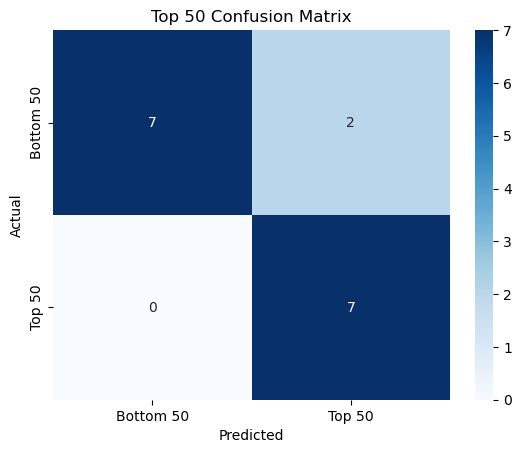

In [50]:
log_y_pred = clf.predict(x_test_bin)
conf_matrix = confusion_matrix(y_test_bin, log_y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bottom 50', 'Top 50'], yticklabels=['Bottom 50', 'Top 50'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Top 50 Confusion Matrix')
plt.show()

### Decision Boundary Graphs for Logistic Regression

To thoroughly understand the performance of our Logistic Regression model, we will generate a series of graphs that visualize the decision boundaries for different pairs of features. These graphs allow us to visualize how the Logistic Regression model sperates the classes, Top 50 and not Top 50, based on different pairs of features. We can also see, by plotting different pairs of features, how different features interact with eah other and contribute to the model's classification perfomance. By observing which feature combinations show the clearest seperations, we can gain insights into which features are most informative for classifying players rank. 

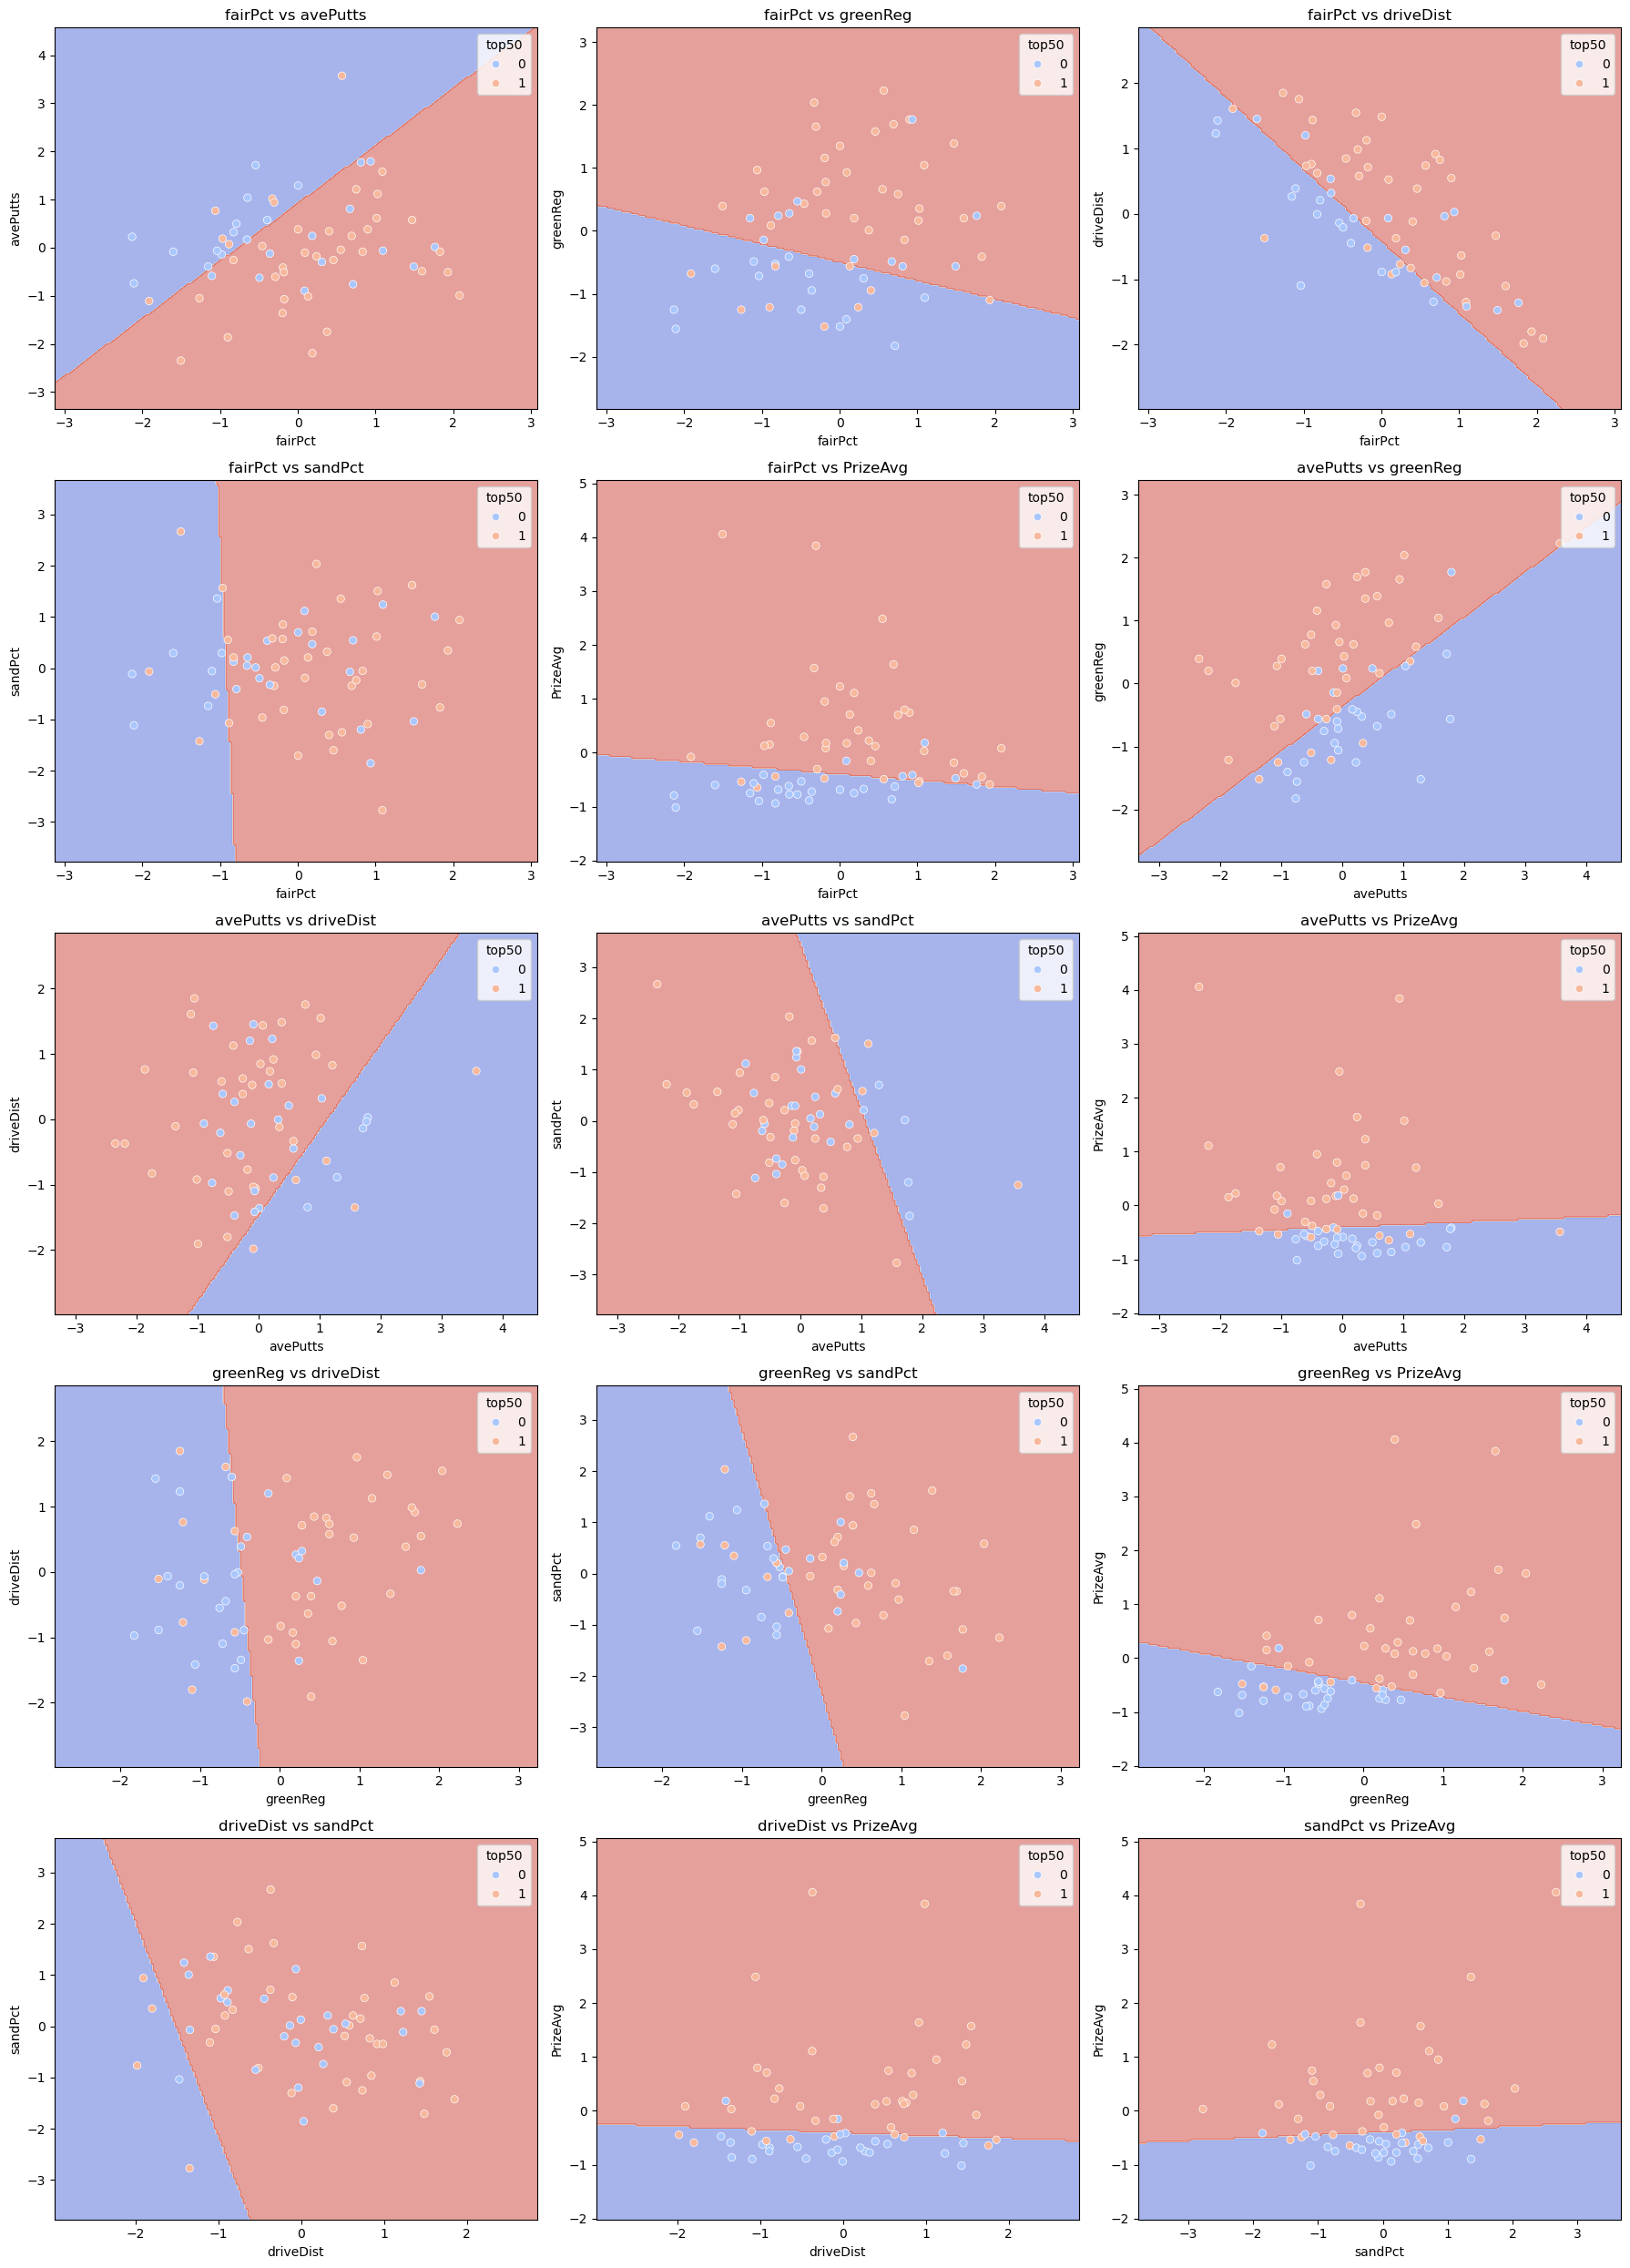

In [51]:
num_pairs = len(list(itertools.combinations(features, 2)))

n_cols = 3 
n_rows = (num_pairs + n_cols - 1) // n_cols  
 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*6, n_rows*5))

axes = axes.flatten()

for idx, (feature1, feature2) in enumerate(itertools.combinations(features, 2)):
    feature1_index = features.index(feature1)
    feature2_index = features.index(feature2)
    x_subset = x_scaled[:, [feature1_index, feature2_index]]

    clf = LogisticRegression()
    clf.fit(x_subset, y_binary)
    
    axis = axes[idx]
    db_display = DecisionBoundaryDisplay.from_estimator(
        clf,
        x_subset,
        grid_resolution=200,
        response_method="predict",
        cmap='coolwarm',
        alpha=0.5,
        ax=axis
    )
    
    x_subset_df = pd.DataFrame(x_subset, columns=[feature1, feature2])
    df_plot = pd.concat([x_subset_df, y_binary.reset_index(drop=True).rename('top50')], axis=1)
    sns.scatterplot(data=df_plot, x=feature1, y=feature2, hue='top50', ax=axis, palette='coolwarm')
    
    axis.set_title(f'{feature1} vs {feature2}')
    axis.set_xlabel(feature1)
    axis.set_ylabel(feature2)

for i in range(len(axes)):
    if i >= num_pairs:
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


### K-Nearest Neighbors

To thoroughly understand the performance of the regression models, we have integrated the K-Nearest Neighbors (KNN) algorithm into the analysis. The KNN algorithm helps to predict the player rankings based on their performance statistics.KNN achieves this by considering the 'k' most similar players in terms of the perfomance features. 

By leveraging this technique, we can make informed predictions by analyzing the local neighborhoods of each data point and we can evaluate how well the model estimates rankings and identify which features are most impactful. 

In [52]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)
r2_knn = r2_score(y_test, y_pred_knn)
print(f"KNN R^2 Score: {r2_knn}")

KNN R^2 Score: 0.4293256047263405


A low $R^2$ score from KNN indicates that the KNN regression explains only a limited amount fo the variance in players rankings and that the current configuration isn't optimal.

### KNN Cross Validation

To ensure the robustness and reliability of our KNN model, we implement cross validation. The cross validation, specifically k-fold cross validation, is similar to the one we did for Linear Regression cross validation - where we divided the dataset into 'k' subsets and trained the model 'k' times, each time using a different subset as the validation set and the remaining subsets as the training set. This technique helps in assessing the model's performance more reliably by mitigating the risk of overfitting and providing a better estimate of its generalization ability. By averaging the results across all folds, we gain a comprehensive understanding of how well our KNN model performs on unseen data.

In [53]:
import numpy as np
scores_knn = cross_val_score(knn, x, y, cv = kf, scoring = 'r2')
scores_knn_mean = np.mean(scores_knn)
print(scores_knn)
print(scores_knn_mean)

[0.78832832 0.8128063  0.83865806 0.28889828 0.8624375 ]
0.718225692671043


The average $R^2$ score for KNN cross validation indicates that KNN model performs well and captures a significant portion of the variance in player rankings. It demonstrates strong predictive power and good generalizability.

### KNN Regression Graphs

To thoroughly evaluate the performance of our KNN regression model, we generate a series of graphs. These graphs are designed to visualize the relationship between actual and predicted player rankings, providing insight into the model's predictive accuracy. By comparing the performance of KNN with different values of 'k', we aim to determine the optimal number of neighbors that yields the most accurate predictions.

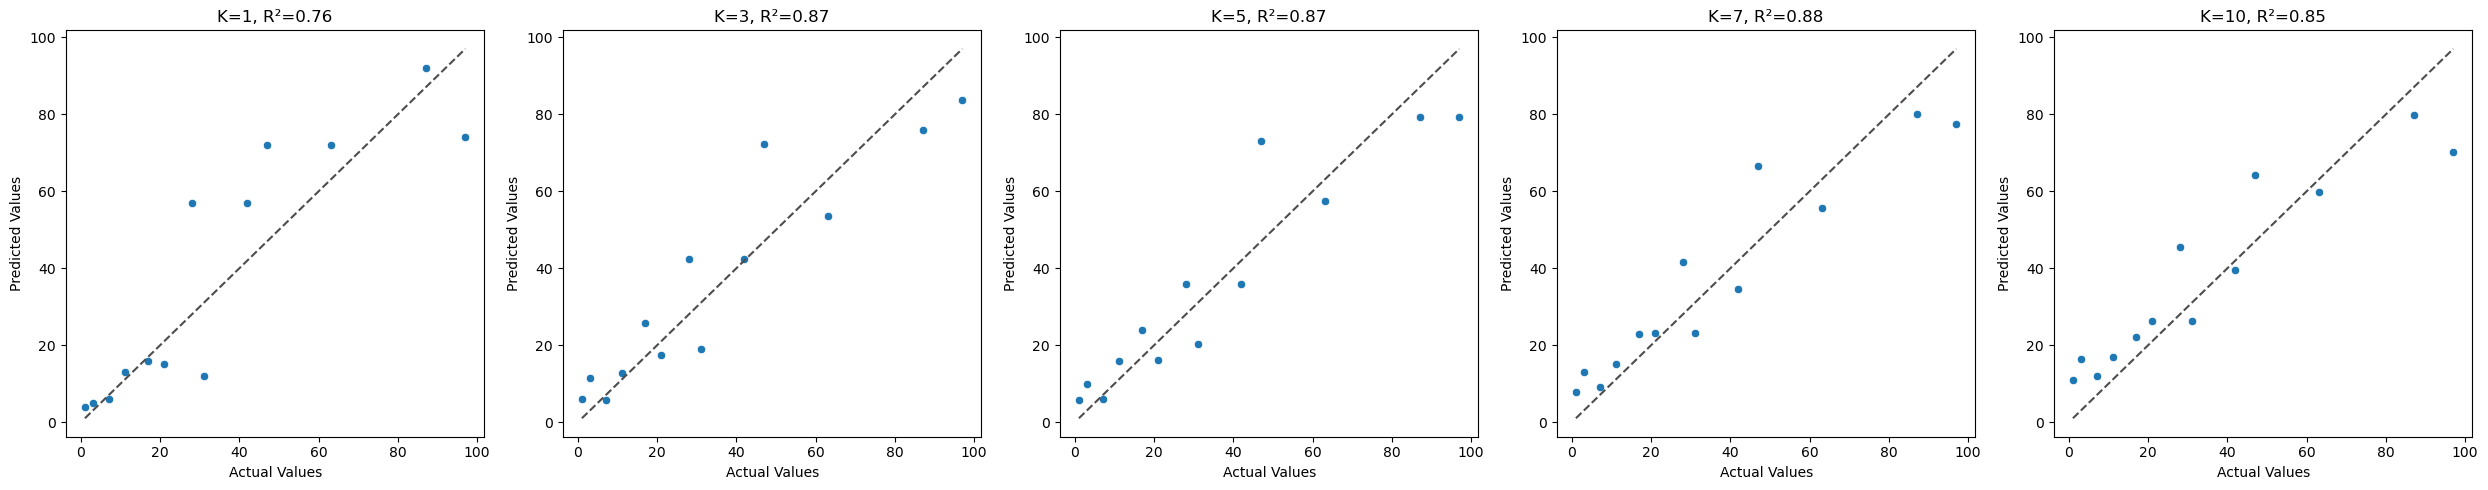

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

k_values = [1, 3, 5, 7, 10]

fig, axes = plt.subplots(nrows=1, ncols=len(k_values), figsize=(5 * len(k_values), 5))

for idx, k in enumerate(k_values):
    knn = KNeighborsRegressor(n_neighbors=k)
    
    knn.fit(x_train, y_train)
    
    y_pred_knn = knn.predict(x_test)
    
    r2_knn = r2_score(y_test, y_pred_knn)
    
    sns.scatterplot(x=y_test, y=y_pred_knn, ax=axes[idx])
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], ls="--", c=".3")
    axes[idx].set_title(f'K={k}, R²={r2_knn:.2f}')
    axes[idx].set_xlabel('Actual Values')
    axes[idx].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

### Random Forest Regression

Random Forest is a learning method that is relatively new to me and required some reading up on. Random Forest constructs multiple decision trees during training and outputting the average of the predictions. It helps to improve accuracy and control overfitting. Here, we want to see how well Random Forest Regression can predict the ranking based on our features.

Random Forest Classification Score: 0.8125


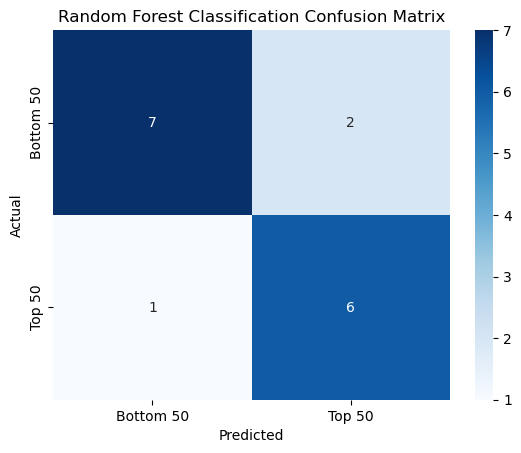

In [55]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=1)
rf_clf.fit(x_train_bin, y_train_bin)
rf_score = rf_clf.score(x_test_bin, y_test_bin)
rf_y_pred = rf_clf.predict(x_test_bin)

print(f'Random Forest Classification Score: {rf_score}')

conf_matrix_rf = confusion_matrix(y_test_bin, rf_y_pred)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Bottom 50', 'Top 50'], yticklabels=['Bottom 50', 'Top 50'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Classification Confusion Matrix')
plt.show()

A high classification score suggests that the Random Forest classification model is performing  well, correctly predicting the class for over most of the instances. This indicates a high level of correctness and reliability in distinguishing between Top 50 players and others. 

In [56]:
rf_reg = RandomForestRegressor(n_estimators = 100, random_state = 1)
rf_reg.fit(x_train, y_train)

y_pred_reg = rf_reg.predict(x_test)
rf_r2_reg = r2_score(y_test, y_pred_reg)
print(f'Random Forest Regressor R^2 Score: {rf_r2_reg:.3f}')

Random Forest Regressor R^2 Score: 0.892


Similar to the $R^2$ score for the Random Forest Classifier, the high $R^2$ score for Random Forest Regression indicates that the model performs well in predicting if a player is the Top 50.

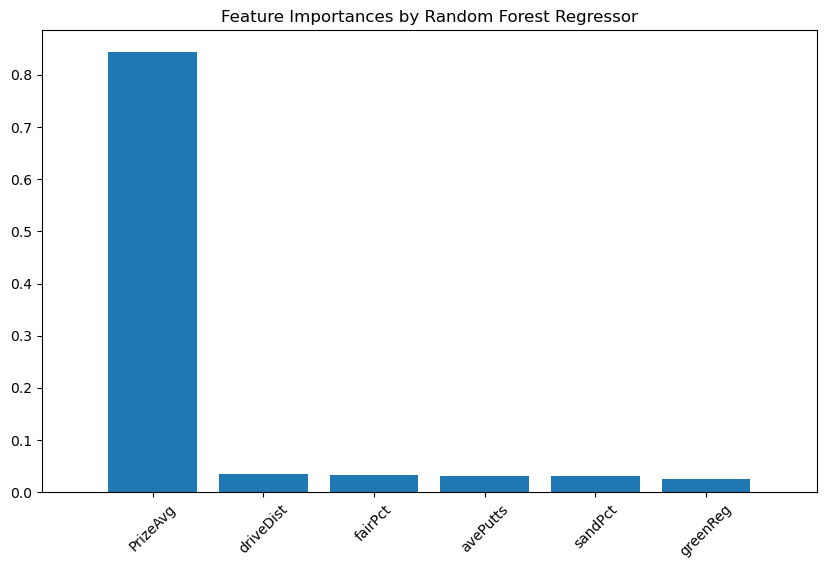

In [57]:
importances = rf_reg.feature_importances_
feature_names = x.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances by Random Forest Regressor")
plt.bar(range(x.shape[1]), importances[indices], align="center")
plt.xticks(range(x.shape[1]), feature_names[indices], rotation=45)
plt.xlim([-1, x.shape[1]])
plt.show()

From graph, we can see that 'PrizeAvg' holds more importance over the other features in distinguinshing whether a player is in the Top 50 or not in the Top 50.

### Conclusion

This project aimed to explore the relationship between various performance indicators and player rankings in the LPGA 2022. By utilizing exploratory data analysis and several machine learning models, we derived insightful conclusions about the predictive power of these performance indicators.

Through cross-validation, our Linear Regression model showed a reasonable $R^2$ score, indicating that there is a notable linear relationship between the features and player rankings. However, Logistic Regression and KNN classification provided improved classification performance, demonstrating their potential in distinguishing between top-ranking players and others.

Nevertheless, Random Forest emerged as the most effective model in both regression and classification tasks. Its superior performance in classification (with an accuracy of 81.25%) and regression (with an $R^2$ score of 0.892) underscores Random Forest's robustness and reliability. Consequently, Random Forest stands out as the best choice for classifying player ranks based on performance features, highlighting its capability to capture complex relationships within the data.

### References:

1. https://www.geeksforgeeks.org/ml-classification-vs-regression/ 
2. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
3. https://docs.python.org/3/library/itertools.html
4. https://www.sciencedirect.com/topics/engineering/confusion-matrix#:~:text=A%20confusion%20matrix%20is%20a,performance%20of%20a%20classification%20algorithm.
5. https://builtin.com/data-science/random-forest-algorithm#:~:text=Random%20Forest%20in%20Classification%20and%20Regression&text=Random%20forest%20adds%20additional%20randomness,a%20random%20subset%20of%20features.
6. https://towardsdatascience.com/random-forest-in-python-24d0893d51c0